In [1]:
# importing libraries
import zipfile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [12]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Define base directory
DATADIR = "/content/drive/MyDrive/dataset/rooms_dataset"
#TRAIN_DIR = os.path.join(DATADIR, "/content/drive/MyDrive/flowers-dataset/train")
#TEST_DIR = os.path.join(DATADIR, "/content/drive/MyDrive/flowers-dataset/test")

CATEGORIES = ["bed_room", "dining_room", "living_room"]

In [4]:
print(os.listdir(DATADIR))


['living_room', 'dining_room', 'bed_room']


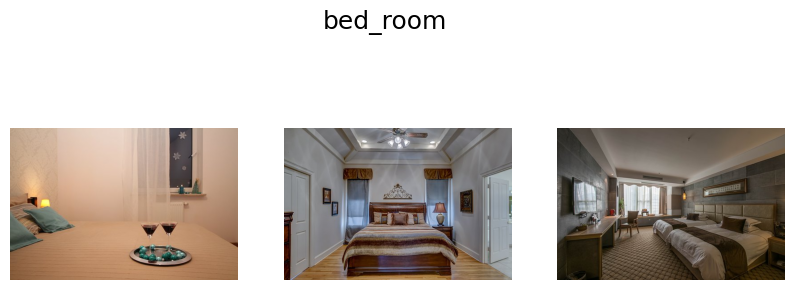

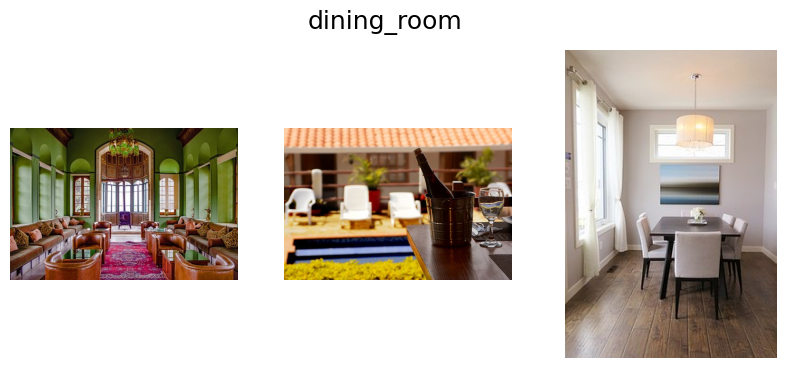

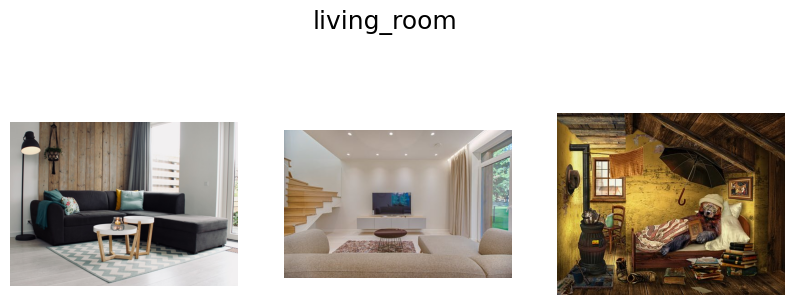

In [7]:
# visulaizing the images
for category in CATEGORIES:
  #constructing the path
  path = os.path.join(DATADIR, category)
  images = os.listdir(path)

  fig, ax = plt.subplots(1, 3, figsize = (10, 4))
  fig.suptitle(f'{category}', fontsize = 18)

  for i in range(3):
    img_name = images[np.random.randint(0, len(images))]
    img_path = os.path.join(path, img_name)
    img_array = cv2.imread(img_path)

    # converting the BGR images to RGB
    img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

    ax[i].imshow(img_rgb)
    ax[i].axis('off')


In [8]:

def count_images(directory):
  for category in CATEGORIES:
    path = os.path.join(directory, category)
    images = os.listdir(path)
    num_images = len(images)
    print(f'{category} : {num_images} images')

count_images(DATADIR)

bed_room : 159 images
dining_room : 86 images
living_room : 148 images


In [9]:
# data augmentation
aug = iaa.Sequential([
    #horizontal flips
    iaa.Fliplr(0.5),
    # randomly croping images upto 10% os it's size
    iaa.Crop(percent = (0, 0.1)),
    # scaling the image between 80% and 120% and rotating it between -25 to 25
    iaa.Affine(scale = (0.8, 1.2), rotate = (-25, 25)),
    # changin the brightness of the images
    iaa.Multiply((0.8, 1.2)),
    # adjusting the contrast of the images
    iaa.LinearContrast((0.75, 1.5))
])

def augment_images(directory, CATEGORIES):
  for category in CATEGORIES:
    path = os.path.join(directory, category)
    for filename in os.listdir(path):
      img = cv2.imread(os.path.join(path, filename))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      augmented_img = aug.augment_image(img)

      new_filename = os.path.splitext(filename)[0] + '_augmented' + os.path.splitext(filename)[1]
      cv2.imwrite(os.path.join(path, new_filename), augmented_img)

augment_images(DATADIR, CATEGORIES)

In [10]:
count_images(DATADIR)

bed_room : 318 images
dining_room : 172 images
living_room : 296 images


In [11]:
img_array.shape

(340, 425, 3)

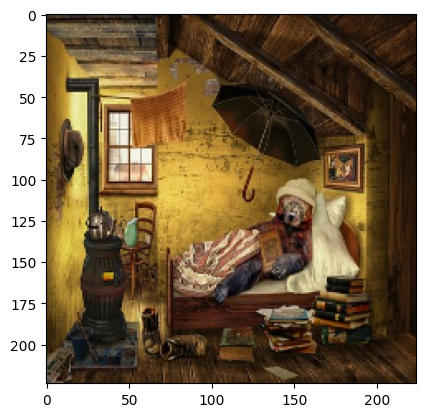

In [12]:

# resizing images
IMG_SIZE = 224
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
img = cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [13]:

# creating training data
training_data = []

def create_training_data():
  for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    labels = CATEGORIES.index(category)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        training_data.append([new_array, labels])
      except Exception as e:
        pass

create_training_data()

In [14]:
len(training_data)

786

In [15]:

X = []
y = []

for features, label in training_data:
  X.append(features)
  y.append(label)

In [16]:

type(X), type(y)

(list, list)

In [17]:

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)


In [18]:

# train_test_split
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [19]:
print(f'X_train length : {X_train.shape[0]}, X_train Image Size : {X_train.shape[1:3]}, Channel Dimension : {X_train.shape[3]}')
print(f'X_test length : {X_test.shape[0]}, X_test Image Size : {X_test.shape[1:3]}, Channel Dimension : {X_test.shape[3]}')


X_train length : 628, X_train Image Size : (224, 224), Channel Dimension : 3
X_test length : 158, X_test Image Size : (224, 224), Channel Dimension : 3


In [20]:
efficient_net = EfficientNetB0(weights = 'imagenet',
                               include_top = False,
                               input_shape = (IMG_SIZE, IMG_SIZE, 3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
# freezing the bottom layers
for layer in efficient_net.layers:
  layer.trainable = False


In [22]:
# constructing the FC(Dense) layers
model = keras.Sequential([
    efficient_net,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1024, activation = 'relu'),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dense(5, activation = 'softmax'),
])

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

model.fit(X_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.4898 - loss: 1.1292
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.8633 - loss: 0.3415
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.9331 - loss: 0.1883
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.9753 - loss: 0.0895
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.9780 - loss: 0.0859
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.9727 - loss: 0.0738
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.9801 - loss: 0.0612
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.9745 - loss: 0.0689
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9789 - loss: 0.0447
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9865 - loss: 0.0365


In [23]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy : {accuracy * 100}')


5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8848 - loss: 0.5602
Model Accuracy : 88.60759735107422


In [24]:
pred = np.argmax(model.predict(X_test), axis = -1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step


In [25]:
pred

array([2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 2, 2, 2, 1,
       0, 1, 0, 0, 2, 1, 2, 1, 0, 2, 0, 0, 0, 1, 2, 2, 2, 0, 2, 1, 2, 2,
       2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 1, 0, 2, 1, 2, 2, 0, 2, 0, 0,
       2, 1, 0, 2, 2, 2, 0, 0, 2, 1, 0, 2, 1, 2, 0, 0, 2, 0, 2, 0, 2, 1,
       2, 2, 1, 1, 2, 0, 0, 0, 2, 1, 2, 2, 2, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 2, 0, 0, 2, 1, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 1, 2, 2, 2, 1, 1,
       0, 1, 0, 0, 2, 2, 1, 0, 0, 1, 1, 2, 0, 1, 0, 2, 0, 1, 2, 2, 2, 0,
       0, 1, 2, 1])

In [26]:

y_test[10:15]

array([1, 0, 0, 2, 0])

In [27]:

pred[10:15]

array([1, 0, 0, 1, 0])

In [28]:

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88        57
           1       0.97      0.91      0.94        34
           2       0.90      0.84      0.87        67

    accuracy                           0.89       158
   macro avg       0.90      0.89      0.89       158
weighted avg       0.89      0.89      0.89       158



Text(50.722222222222214, 0.5, 'ACTUAL')

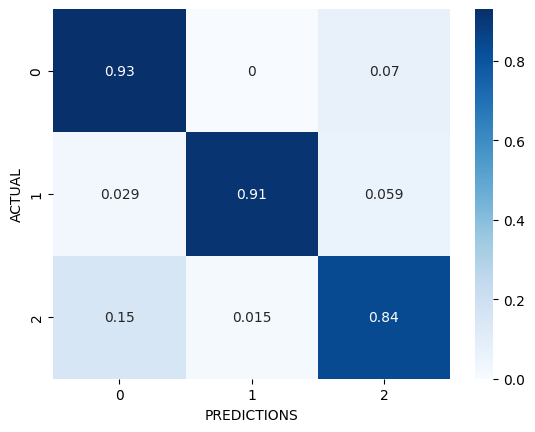

In [29]:
cf = confusion_matrix(y_test, pred, normalize = 'true')
sns.heatmap(cf, annot = True, cmap = 'Blues');
plt.xlabel('PREDICTIONS')
plt.ylabel('ACTUAL')

In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,566,900 (36.49 MB)

 Trainable params: 1,839,109 (7.02 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 3,678,220 (14.03 MB)